In [3]:
import numpy as np
import ast
from scipy.ndimage.filters import convolve
from scipy.signal import correlate
import matplotlib.pyplot as plt
import tensorflow as tf

In [47]:
# Constants

w = 1
b = -1

In [41]:
def visualize_conv(input, filter, padding=False, full_wb_range=True):
    if padding:
        mode = 'same'
    else:
        mode = 'valid'   
    
    output = correlate(input, filter, mode=mode)
    ratio = input.shape[1] / filter.shape[1]
    max_value = np.sum(abs(filter)) * w
     
    fig, axs = plt.subplots(1, 3, gridspec_kw = dict(width_ratios = [ratio,1,ratio]))
    axs[0].matshow(input, cmap=plt.cm.gray)
    axs[0].set_title('Input')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    axs[1].matshow(filter, cmap=plt.cm.gray)
    axs[1].set_title('Filter')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    if full_wb_range:
        axs[2].matshow(output, cmap=plt.cm.gray)
    else:
        axs[2].matshow(output, cmap=plt.cm.gray, vmin=-max_value, vmax=max_value)
    axs[2].set_title('Output')
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    
    return output

In [48]:
# Basic input patterns

v_stripes = np.array([[b, w, b, w], 
                  [b, w, b, w],
                  [b, w, b, w],
                  [b, w, b, w]])

h_stripes = np.array([[b, b, b, b], 
                  [w, w, w, w],
                  [b, b, b, b],
                  [w, w, w, w]])

checker = np.array([[b, w, b, w],
                    [w, b, w, b],
                    [b, w, b, w],
                    [w, b, w, b]])

def get_rand_input(size=4):
    if type(size) == tuple:
        dims = size
    elif type(size) == int:
        dims = (size, size)
            
    return np.random.choice([b,w],dims)

# basic filters 

v_edge_22 = np.array([[-1, 1],
                      [-1, 1]])

h_edge_22 = np.array([[-1, -1],
                      [1, 1]])

diag_22 = np.array([[1, -1],
                    [-1, 1]])

diff_21 = np.array([[-1],
                   [1]])

same_21 = np.array([[1],
                    [1]])

v_edge_33 = np.array([[-1, 2, -1],
                      [-1, 2, -1],
                      [-1, 2, -1]])

h_edge_33 = np.array([[-1, -1, -1],
                      [2, 2, 2],
                      [-1, -1, -1]])

identity_33 = np.array([[0, 0, 0],
                        [0, 1, 0],
                        [0, 0, 0]])


def get_rand_filter(dims=(2,2)):
    return np.random.choice([1,-1], dims)

## With padding

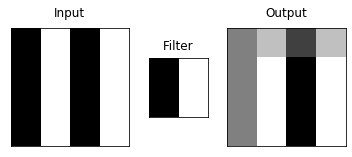

In [36]:
output = visualize_conv(v_stripes, v_edge_22, padding=True, full_wb_range=True)

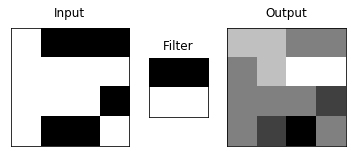

In [37]:
output = visualize_conv(get_rand_input(), h_edge_22, padding=True, full_wb_range=True)

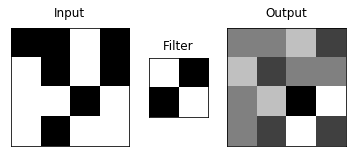

In [38]:
output = visualize_conv(get_rand_input(), diag_22, padding=True, full_wb_range=True)

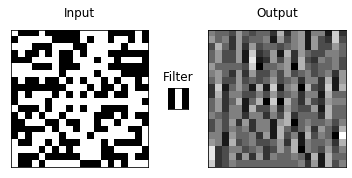

In [39]:
output = visualize_conv(get_rand_input(20), v_edge_33, padding=True, full_wb_range=True)

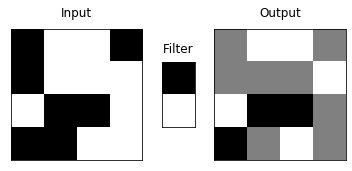

In [48]:
output = visualize_conv(get_rand_input(4), diff_21, padding=True, full_wb_range=True)

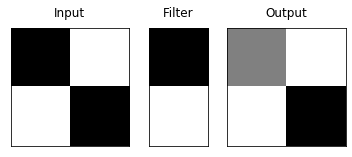

In [55]:
output = visualize_conv(get_rand_input(2), diff_21, padding=True, full_wb_range=True)

## Without padding

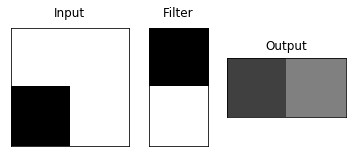

In [42]:
output = visualize_conv(get_rand_input(2), diff_21, padding=False, full_wb_range=False)

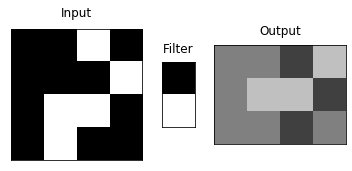

In [43]:
output = visualize_conv(get_rand_input(4), diff_21, padding=False, full_wb_range=False)

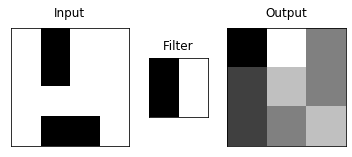

In [57]:
output = visualize_conv_no_pad(get_rand_input(4), v_edge_22, padding=False, full_wb_range=False)

[[-2]
 [ 0]]


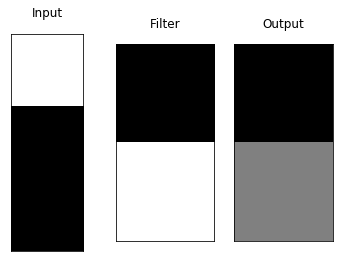

In [51]:
output = visualize_conv(get_rand_input((3,1)), diff_21, padding=False, full_wb_range=False)

print(output)